### Identify Blood Cell Subtype from Image
- Mononuclear (Lymphocyte + Monocyte) vs Polynuclear (Neutrophil + Eosinophil)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.enabled

True

In [4]:
PATH = './dataset-master/'
sz = 224
# arch = resnext101_64
bs = 64
!ls {PATH}

Annotations  JPEGImages  labels.csv  models  test  tmp	train  valid


In [5]:
os.listdir(f'{PATH}valid')

['poly', 'mono']

In [6]:
files = os.listdir(f'{PATH}valid/poly')[:5]
files

['BloodImage_00168.jpg',
 'BloodImage_00159.jpg',
 'BloodImage_00177.jpg',
 'BloodImage_00115.jpg',
 'BloodImage_00133.jpg']

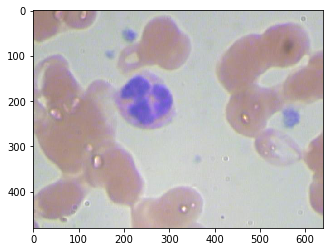

In [7]:
img = plt.imread(f'{PATH}valid/poly/{files[1]}')
plt.imshow(img);

In [8]:
img.shape

(480, 640, 3)

In [9]:
os.makedirs('/cache/tmp', exist_ok=True)
!ln -fs /cache/tmp {PATH}

In [17]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 5)

epoch      trn_loss   val_loss   accuracy        
    0      0.870843   0.497959   0.8       
    1      0.773969   0.507242   0.826667        
    2      0.68701    0.517365   0.826667        
    3      0.598722   0.515378   0.826667        
    4      0.536035   0.512038   0.813333        



[array([0.51204]), 0.8133333373069763]

In [18]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [20]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   accuracy        
    0      0.95593    2.253484   0.813333  



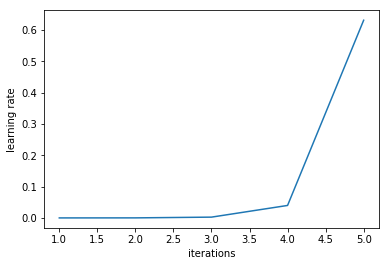

In [21]:
learn.sched.plot_lr()

In [22]:
#learn.sched.plot()

In [23]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [24]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [25]:
ims = np.stack([get_augs() for i in range(6)])

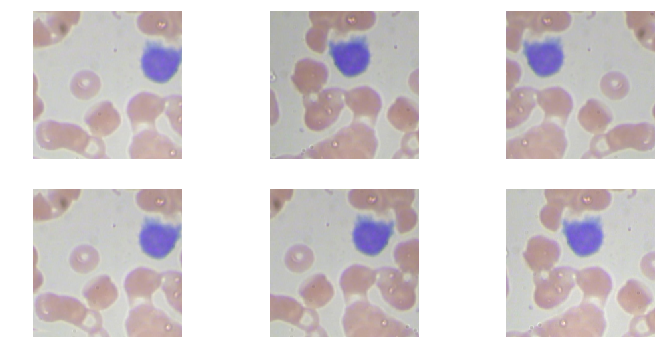

In [26]:
plots(ims, rows=2)

In [27]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [28]:
learn.fit(1e-2, 10)

epoch      trn_loss   val_loss   accuracy        
    0      0.834082   0.628819   0.68      
    1      0.725327   0.533592   0.773333        
    2      0.64945    0.505327   0.786667        
    3      0.584628   0.495823   0.786667        
    4      0.523864   0.50167    0.786667        
    5      0.466572   0.515766   0.786667        
    6      0.418438   0.533121   0.773333        
    7      0.38171    0.547905   0.72            
    8      0.349266   0.561864   0.72            
    9      0.329101   0.56841    0.746667        



[array([0.56841]), 0.7466666706403097]

In [29]:
learn.precompute=False

In [30]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.394327   0.571853   0.733333  
    1      0.390355   0.589152   0.693333                
    2      0.372213   0.585311   0.693333                



[array([0.58531]), 0.6933333325386047]

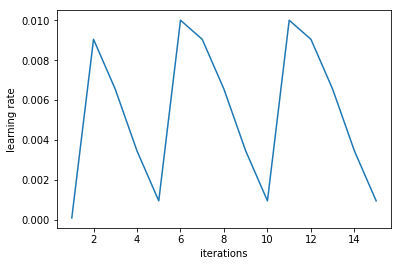

In [31]:
learn.sched.plot_lr()

In [32]:
learn.unfreeze()

In [33]:
lr=np.array([1e-4,1e-3,1e-2])

In [34]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.48209    0.503314   0.76      
    1      0.508434   0.413905   0.813333                
    2      0.482503   0.329104   0.84                    
    3      0.453202   0.354807   0.853333                
    4      0.410675   0.409029   0.853333                
    5      0.382706   0.429164   0.853333                
    6      0.35292    0.417843   0.853333                



[array([0.41784]), 0.8533333373069764]

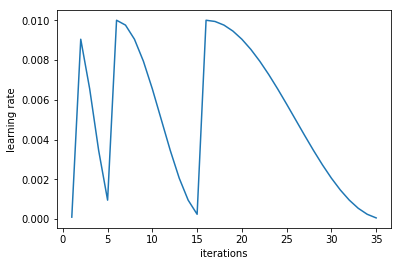

In [35]:
learn.sched.plot_lr()

In [36]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [37]:
accuracy_np(probs, y)

0.8533333333333334

In [38]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 6  8]
 [ 3 58]]


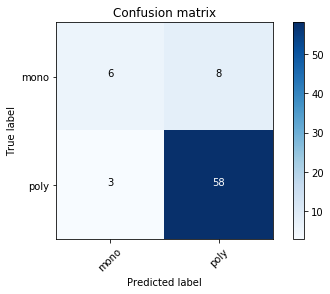

In [40]:
plot_confusion_matrix(cm, data.classes)